### Lets do a more full scale analysis of our data with a few different types of models

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb

First, we'll extract the data for a single run. This should feature 10 different gates

In [ ]:
df = pd.read_csv('data/run1.csv')
df.head(2)

,gate_type,voltage,thickness,clock_cycle,t_rise,t_fall,t_delay
0,buffer,0.3,0.1,100,3.131324e-12,3.17279e-12,9.921646e-12
1,buffer,0.4,0.1,100,8.473565e-13,1.456597e-12,7.269524e-12


In [ ]:
unique_gates = list(df.gate_type.unique())
np.array(unique_gates)

array(['buffer', 'inv_x1', 'inv_x2', 'inv_x4', 'nand2', 'nand3', 'nand4',
       'nor2', 'nor3', 'nor4'], dtype='<U6')

We'll need to drop some failed values in our nand4 gate in order to proceed, you can see the heatmap at the bottom of notebook #3 in order to confirm the need for this

In [ ]:
#these are the bad t_fall values in nand4 that need to be dropped
nand4_drop_idxs = ((df['gate_type'] == 'nand4') & (df['t_fall'] == ' FAILED')).values
nand4_drop_idxs.sum()

36

In [ ]:
df = df.loc[~nand4_drop_idxs].reset_index(drop=True)
df.shape

(11304, 7)

Lets flesh out a few functions that will make our lives easier in order to index into our data appropriately and drop whatever items we might need to be removed

In [ ]:
def get_gate(gate_type='buffer'): return df[df.gate_type == gate_type]

In [ ]:
def get_gate_xy(gate_type='buffer'):
    y_drop = 't_fall' if gate_type == 'buffer' else 't_rise'
    df = get_gate(gate_type)
    x_cols = ['clock_cycle', 'thickness', 'voltage']
    y_cols = ['t_delay', 't_rise', 't_fall']
    y_cols.remove(y_drop)
    x = np.vstack(df[x_cols].values).astype('float')
    y = np.vstack(np.vstack(df[y_cols].values)).astype('float')
    return x, y

In [ ]:
x, y = get_gate_xy('nor3')
x.shape, y.shape

((1134, 3), (1134, 2))

In [ ]:
gate_dict = dict.fromkeys(unique_gates)
gate_dict

{'buffer': None,
 'inv_x1': None,
 'inv_x2': None,
 'inv_x4': None,
 'nand2': None,
 'nand3': None,
 'nand4': None,
 'nor2': None,
 'nor3': None,
 'nor4': None}

In [ ]:
for gate in unique_gates: 
    gate_dict[gate] = get_gate_xy(gate_type=gate)

In [ ]:
x, y = gate_dict['buffer']
x_tr, x_val, y_tr, y_val = train_test_split(x,y)
x_tr.shape, x_val.shape, y_tr.shape, y_val.shape

((850, 3), (284, 3), (850, 2), (284, 2))

### Ok, we have a dictionary with our gates that we can quickly index into and do our model training and evaluation with

## Lets flesh out and then add some new models into the mix for our analysis.

We'll add the following models: 

- ElasticNet: (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)
- Lasso: (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
- LassoCV: (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)
- ElasticNetCv: (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html)

To our previously used models:
- Ridge Regression: (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)
- RandomForests: (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
- XGBoost: (https://xgboost.readthedocs.io/en/stable/) --> Gradient Boosted Trees

We'll also introduce and begin to make use of using Polynomial Features (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) to help our models by introducing polynomial combinations of our independent variables (x)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet, LassoCV, MultiTaskLassoCV, MultiTaskElasticNetCV
from sklearn import linear_model

In [ ]:
PolynomialFeatures(2).fit_transform(x).shape

(1134, 10)

In [ ]:
#without polynomial features.....
regr = ElasticNet()
regr.fit(x_tr,y_tr);
#print(regr.coef_)
print(regr.score(x_val,y_val))

-0.010715832683537596


In [ ]:
#with polynomial features.....
regr = ElasticNet()
poly_x = PolynomialFeatures(2).fit_transform(x_tr)
regr.fit(poly_x, y_tr);
poly_x_val = PolynomialFeatures(2).fit_transform(x_val)
print(regr.score(poly_x_val, y_val))

0.6796738281108605


In [ ]:
stacked_poly_x = np.vstack([poly_x, poly_x_val])
stacked_poly_x.shape, x.shape

((1134, 10), (1134, 3))

In [ ]:
import timeit
#poly_x.shape, poly_x_val.shape
%timeit regr.predict(stacked_x)

28.9 µs ± 229 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


The models all follow the same pattern in terms of how they are called, so lets wrap them all into a function.
That was ugly and too much repeated code

In [ ]:
#lets introduce partial functions to clean up our code a little
from functools import partial

In [ ]:
def normalize(x): return x / x.min() #used to normalize our Y values

def poly_x(x, num_poly=2): return PolynomialFeatures(num_poly).fit_transform(x)

def do_simple_model(x, y, model_name='ridge', num_poly=2, alpha=1.0, norm_y=True, print_vals=True,
                   get_model=False):
    x_tr, x_val, y_tr, y_val = train_test_split(x,y)
    
    #lets convert our independent variable into a different polynomial combination
    if num_poly: x_tr, x_val = poly_x(x_tr, num_poly), poly_x(x_val, num_poly)
    
    alps = np.logspace(-5,-1)
    
    if model_name   == 'ridge': model = Ridge(alpha=alpha, random_state=0)
    elif model_name == 'ridge-cv': model = RidgeCV()#alphas=alps)
    #elif model_name == 'lasso': model = linear_model.Lasso(alpha=alpha,random_state=0)
    #elif model_name == 'elastic': model = ElasticNet(random_state=0)
    elif model_name == 'lasso': model = MultiTaskLassoCV(random_state=0, alphas=alps, max_iter=10000)
    elif model_name == 'elastic': model = MultiTaskElasticNetCV(random_state=0, alphas=alps, max_iter=10000,
                                                                  l1_ratio=np.arange(0.1, 1, 0.1))
    elif model_name == 'random_forest': model = RandomForestRegressor(max_depth=100, random_state=0)
    elif model_name == 'xgboost': model = xgb.XGBRegressor(eval_metric='rmse', random_state=0)
    
    #normally want to normalize y values for regression problem
    if norm_y: y_tr, y_val = normalize(y_tr), normalize(y_val)
    
    #now lets fit our model to our training data
    model.fit(x_tr, y_tr)
    
    #we'll predict our R2 score on only the validation data
    r2score = model.score(x_val, y_val)
    if print_vals: print(f'for a {model_name} model, the validation R2 score is: {r2score:2f}')
    if get_model: return model
    return r2score

In [ ]:
def run_models(gate_type='buffer', random_state=0, print_vals=True):
    print(f'-----Analyzing the {gate_type} gate-----')
    x, y = gate_dict[gate_type]
    scores = []
    do_model = partial(do_simple_model, x, y, print_vals=print_vals)
    #do_model(model_name='lasso')
    #do_model(model_name='elastic')
    scores.append(do_model(model_name='ridge', norm_y=False))
    #scores.append(do_model(model_name='ridge-cv', norm_y=True))
    scores.append(do_model(model_name='lasso'))
    scores.append(do_model(model_name='elastic'))
    scores.append(do_model(model_name='random_forest', num_poly=False))
    scores.append(do_model(model_name='xgboost', num_poly=False))
    return scores
    print('\n')

In [ ]:
#test run on just the buffer gate
_ = run_models(print_vals=True)

-----Analyzing the buffer gate-----
for a ridge model, the validation R2 score is: 0.814796
for a lasso model, the validation R2 score is: 0.919803
for a elastic model, the validation R2 score is: 0.934237
for a random_forest model, the validation R2 score is: 1.000000
for a xgboost model, the validation R2 score is: 1.000000


In [ ]:
def model_gates(gate_dict, print_vals=True):
    gate_scores = {}
    gate_types = (gate_dict.keys())
    for gate_type in gate_types: 
        scores = run_models(gate_type, print_vals=print_vals)
        gate_scores[gate_type] = scores
    results_df = pd.DataFrame(gate_scores).T.rename(columns={0:'ridge', 1:'lasso', 2: 'elasticnet',
                                                        3: 'random-forest', 4: 'xgboost'}).T
    return results_df

In [ ]:
results_df = model_gates(gate_dict, print_vals=False)
results_df

-----Analyzing the buffer gate-----
-----Analyzing the inv_x1 gate-----
-----Analyzing the inv_x2 gate-----
-----Analyzing the inv_x4 gate-----
-----Analyzing the nand2 gate-----
-----Analyzing the nand3 gate-----
-----Analyzing the nand4 gate-----
-----Analyzing the nor2 gate-----
-----Analyzing the nor3 gate-----
-----Analyzing the nor4 gate-----


,buffer,inv_x1,inv_x2,inv_x4,nand2,nand3,nand4,nor2,nor3,nor4
ridge,0.798751,0.877214,0.872157,0.877183,0.876580,0.939227,0.831790,0.836751,0.848048,0.834470
lasso,0.928708,0.928597,0.929091,0.923109,0.877278,0.946458,0.906957,0.924468,0.913901,0.911009
elasticnet,0.928978,0.925248,0.923985,0.926931,0.899043,0.954729,0.905021,0.913856,0.904509,0.903856
random-forest,1.000000,0.999999,1.000000,1.000000,1.000000,1.000000,1.000000,0.999999,1.000000,1.000000
xgboost,0.999999,1.000000,1.000000,1.000000,0.999999,0.999999,0.999999,0.999999,1.000000,0.999999


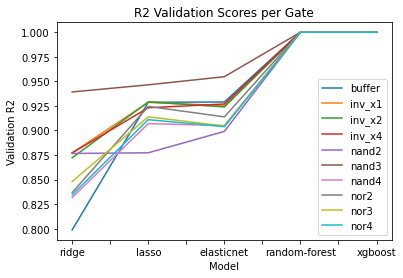

In [ ]:
results_df.plot.line(title='R2 Validation Scores per Gate',
                    xlabel='Model', ylabel='Validation R2');

## add inference time calculcation + plot for slide

In [ ]:
def inf_models(gate_type='buffer', random_state=0, print_vals=True):
    print(f'-----Analyzing the {gate_type} gate-----')
    x, y = gate_dict[gate_type]
    models = []
    do_model = partial(do_simple_model, x, y, print_vals=print_vals)
    #do_model(model_name='lasso')
    #do_model(model_name='elastic')
    models.append(do_model(model_name='ridge', norm_y=False, get_model=True))
    #scores.append(do_model(model_name='ridge-cv', norm_y=True))
    models.append(do_model(model_name='lasso', get_model=True))
    models.append(do_model(model_name='elastic', get_model=True))
    models.append(do_model(model_name='random_forest', num_poly=False, get_model=True))
    models.append(do_model(model_name='xgboost', num_poly=False, get_model=True))
    return models

In [ ]:
inf_models = inf_models()
len(inf_models)

-----Analyzing the buffer gate-----
for a ridge model, the validation R2 score is: 0.813206
for a lasso model, the validation R2 score is: 0.932476
for a elastic model, the validation R2 score is: 0.926208
for a random_forest model, the validation R2 score is: 1.000000
for a xgboost model, the validation R2 score is: 1.000000


5

In [ ]:
[inf_models[x].predict(stacked_x).shape for x in range(len(inf_models)-2)]

[(1134, 2), (1134, 2), (1134, 2)]

In [ ]:
%timeit inf_models[0].predict(stacked_x) #ridge model

26.3 µs ± 205 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%timeit inf_models[1].predict(stacked_x) # lasso

27.3 µs ± 130 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%timeit inf_models[2].predict(stacked_x) # elastic

27.5 µs ± 210 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%timeit inf_models[3].predict(x) # Random Forest

4.04 ms ± 47.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%timeit inf_models[4].predict(x) # XGBoost

891 µs ± 10.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
inf_times = {'ridge' : 26.3*1e-6,
            'lasso' : 27.3*1e-6,
            'elastic' : 27.5 * 1e-6,
            'random-forest' : 4.04 * 1e-3,
            'xgboost' : 891 * 1e-6}
inf_times

{'ridge': 2.63e-05,
 'lasso': 2.73e-05,
 'elastic': 2.7499999999999998e-05,
 'random-forest': 0.00404,
 'xgboost': 0.000891}

Text(0.5, 0, 'Model')

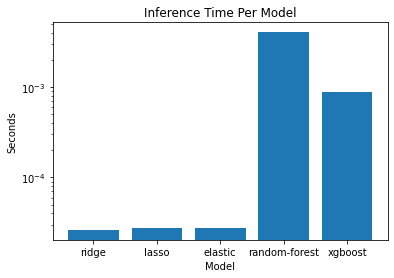

In [ ]:
plt.bar(x=inf_times.keys(), height=inf_times.values())
plt.yscale('log')
plt.title('Inference Time Per Model')
plt.ylabel('Seconds')
plt.xlabel('Model')

#### probably couldve wrapped infernce stuff up into function

To see a printout of all the results one by one.....

In [ ]:
for gate_type in gate_dict.keys(): run_models(gate_type, random_state=123)

-----Analyzing buffer gates-----
for a ridge model, the validation R2 score is: 0.813969
for a lasso-cv model, the validation R2 score is: 0.693241
for a elastic-cv model, the validation R2 score is: 0.706021
for a random_forest model, the validation R2 score is: 1.000000
for a xgboost model, the validation R2 score is: 1.000000


-----Analyzing inv_x1 gates-----
for a ridge model, the validation R2 score is: 0.876524
for a lasso-cv model, the validation R2 score is: 0.811746
for a elastic-cv model, the validation R2 score is: 0.838664
for a random_forest model, the validation R2 score is: 1.000000
for a xgboost model, the validation R2 score is: 1.000000


-----Analyzing inv_x2 gates-----
for a ridge model, the validation R2 score is: 0.866308
for a lasso-cv model, the validation R2 score is: 0.823860
for a elastic-cv model, the validation R2 score is: 0.826822
for a random_forest model, the validation R2 score is: 1.000000
for a xgboost model, the validation R2 score is: 0.999999


-

### Looks like our Random Forest and XGBoost models are still doing the best at the moment, but will that hold after a parameter search? (all of the models are using their default parameters at the moment)

# To do:

- Plotting functionality
- Save results into Csv